# Figures for "Discovering sparse control strategies in C. elegans"
Author: Edward D. Lee  
Email: edlee@csh.ac.at

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', size=25)

In [94]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from misc.plot import seismic_cmap_kw

from pyutils import *

calc_observables = define_potts_helper_functions(3)[1]

imgdr = os.path.expanduser('~')+'/Dropbox/Research/scotus4/writing/20210811_plos_cb'
assert os.path.isdir(imgdr)

Defining some necessary functions

In [4]:
def draw_one_to_one(ax):
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot(xlim, ylim, 'k-', zorder=0)
    ax.set(xlim=xlim, ylim=ylim)

def plot_fit(n, sisjData, sisjModel, fig=None, ax=None, c='C0',
             draw_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(11,4), ncols=2)
    
    ax[0].plot(sisjData[:n], sisjModel[:n], '.', zorder=1)
    ax[0].plot(sisjData[n:n*2], sisjModel[n:n*2], 'x', zorder=1)
    ax[0].plot(sisjData[n*2:n*3], sisjModel[n*2:n*3], '^', zorder=1)
    ax[0].set(xlabel=r'data $p(s_{\rm i}=k)$',
              ylabel=r'model $p(s_{\rm i}=k)$',
              xlim=[-.02,1.02], ylim=[-.02,1.02], yticks=[0,.5,1.])
    draw_one_to_one(ax[0])
    if draw_legend:
        ax[0].legend((r'$p(s_i=\rm rise)$',r'$p(s_i=\rm fall)$'),
                     handletextpad=.05,
                     borderpad=.2,
                     fontsize=20)

    ax[1].plot(sisjData[n*3:], sisjModel[n*3:], '.', c=c, zorder=1)
    ax[1].set(xlabel=r'data $p(s_{\rm i}=s_{\rm j})$',
              ylabel=r'model $p(s_{\rm i}=s_{\rm j})$',
              xlim=[-.02,1.02], ylim=[-.02,1.02], yticks=[0,.5,1.])
    if draw_legend:
        ax[1].legend((r'$p(s_i=s_j)$',),
                     handletextpad=.05,
                     borderpad=.2,
                     fontsize=20)
    draw_one_to_one(ax[1])

    fig.subplots_adjust(wspace=.5)
    return fig

def extract_pk(X):
    """Calculate p(k) from data."""
    
    Xk = np.zeros((len(X),3), dtype=int)  # number of neurons agreeing on state
    for k in range(3):
        Xk[:,k] = (X==k).sum(1)

    pk = np.bincount(Xk.max(1), minlength=X.shape[1]+1)
    pk = pk[int(np.ceil(X.shape[1]/3)):]
    
    pk = pk/pk.sum()
    return pk

def collective_fit(name):
    soln = MESolution(name, 0)
    model = soln.model()
    X = soln.X()
    sisjData = calc_observables(X).mean(0)
    sisjModel = soln.sisj()
    n = soln.n

    from scipy.special import comb
    def multinomial(params):
        if len(params) == 1:
            return 1
        coeff = (comb(sum(params), params[-1], exact=True) *
                 multinomial(params[:-1]))
        return coeff

    def indpt_model_pk(N):
        pk = np.zeros(N - int(np.ceil(N/3)) + 1)
        for i, c in enumerate(range(int(np.ceil(N/3)), N+1)):
            for a in range(c+1):
                b = N - c - a
                if b<=c:
                    if (c==b and c!=a) or (c==a and c!=b):
                        pk[i] += multinomial([a, b, c]) / 2
                    elif (c==b and c==a):
                        pk[i] += multinomial([a, b, c]) / 6
                    else:
                        pk[i] += multinomial([a, b, c])
        pk /= pk.sum()
        return pk
    
    assert len(model.p)==len(model.allStates)
    
    return X, extract_pk(X), indpt_model_pk(X.shape[1]), extract_pk(model.allStates)

# Mutual information
From "2022-01-09 estimate c-elegans.ipynb"

In [156]:
load_pickle('plotting/sync_mi.p')

['gckeys', 'indmi', 'df']

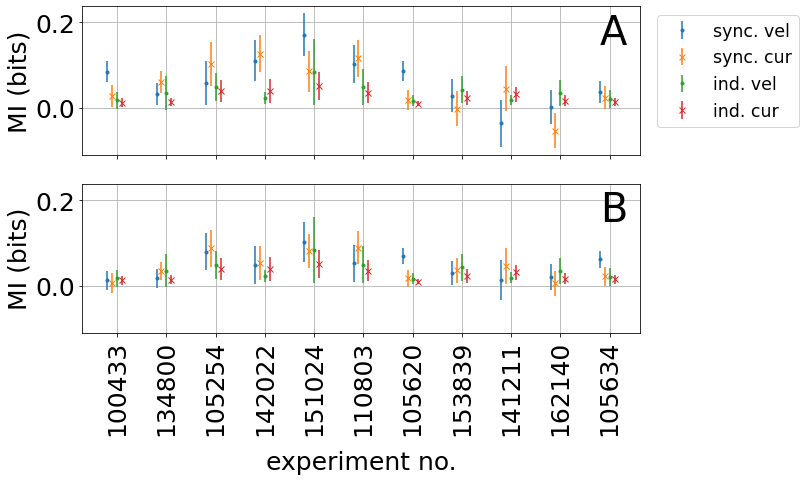

In [188]:
fig, ax = plt.subplots(figsize=(10,6), nrows=2, sharex=True, sharey=True)
h = []

load_pickle('plotting/sync_mi.p')
h.append(ax[0].errorbar(arange(len(df))-.2, df.iloc[:,3], fmt='.', yerr=df.iloc[:,4]))
h.append(ax[0].errorbar(arange(len(df))-.1, df.iloc[:,0], fmt='x', yerr=df.iloc[:,1]))

h.append(ax[0].errorbar(arange(len(df)), [i.mean() for i in indmi['vel']],
                        fmt='.', yerr=[i.std() for i in indmi['vel']]))
h.append(ax[0].errorbar(arange(len(df))+.1, [i.mean() for i in indmi['cur']],
                        fmt='x', yerr=[i.std() for i in indmi['cur']]))

load_pickle('plotting/sync_mi_coarse.p')
h.append(ax[1].errorbar(arange(len(df))-.2, df.iloc[:,3], fmt='.', yerr=df.iloc[:,4]))
h.append(ax[1].errorbar(arange(len(df))-.1, df.iloc[:,0], fmt='x', yerr=df.iloc[:,1]))

h.append(ax[1].errorbar(arange(len(df)), [i.mean() for i in indmi['vel']],
                        fmt='.', yerr=[i.std() for i in indmi['vel']]))
h.append(ax[1].errorbar(arange(len(df))+.1, [i.mean() for i in indmi['cur']],
                        fmt='x', yerr=[i.std() for i in indmi['cur']]))

ax[0].legend(h, ('sync. vel', 'sync. cur', 'ind. vel', 'ind. cur'),
          fontsize='x-small',
          bbox_to_anchor=(1.3, 1))
ax[0].set(ylabel='MI (bits)')
ax[1].set(xticks=range(len(df)), ylabel='MI (bits)')
ax[1].set_xlabel('experiment no.', labelpad=15)
ax[1].set_xticklabels([i[-6:] for i in df.index], rotation=90)
ax[0].grid(True)
ax[1].grid(True)

ax[0].text(9.8, .15, 'A', fontsize=40)
ax[1].text(9.8, .15, 'B', fontsize=40)

fig.savefig(f'{imgdr}/mi_sync.pdf', bbox_inches='tight')

# Pivotal measure comparison
From "2021-06-08 pivotal neurons"

In [93]:
load_pickle('plotting/pivotal_measure_comparison.p')

['counts', 'prin_eigval']

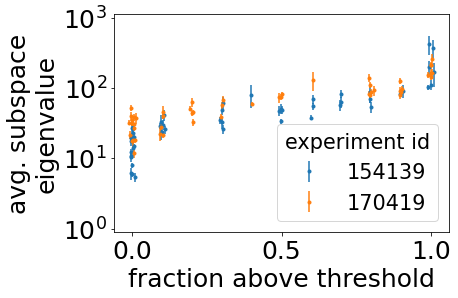

In [97]:
fig, ax = plt.subplots()

ax.errorbar(counts['171017_154139']+np.random.normal(size=50, scale=.005),
            prin_eigval['171017_154139'].mean(0), 
            yerr=prin_eigval['171017_154139'].std(0)/sqrt(10),
            fmt='.')
ax.errorbar(counts['171017_170419']+np.random.normal(size=50, scale=.005),
            prin_eigval['171017_170419'].mean(0), 
            yerr=prin_eigval['171017_170419'].std(0)/sqrt(10), 
            fmt='.')
ax.set(xlabel='fraction above threshold', ylabel='avg. subspace\neigenvalue',
       yscale='log')
ax.set(ylim=(.9,1e3/.9), yticks=[1,10,100,1000])
leg = ax.legend(('154139','170419'), fontsize='small')
leg.set_title('experiment id', prop={'size':'small'})

In [98]:
fig.savefig(f'{imgdr}/piv_measures.pdf', bbox_inches='tight')

# Pivotal neurons histogram
From "2021-06-08 pivotal neurons"

In [137]:
load_pickle('plotting/piv_histogram.p')

['counts']

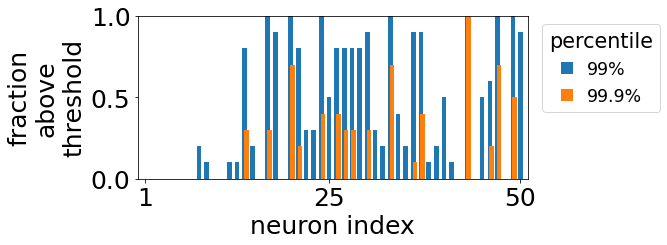

In [140]:
fig, ax = plt.subplots(figsize=(7, 3))

ax.bar(arange(50), counts['171017_170419A_1'], width=.6, align='center')
ax.bar(arange(50)+.2, counts['171017_170419A_.1'], width=.6, align='center')

leg = ax.legend(('99%', '99.9%'), loc=1,
             bbox_to_anchor=(1.36,1), fontsize='x-small', handlelength=.7)
leg.set_title('percentile', prop={'size':'small'})
ax.set(xlabel='neuron index',
       ylabel='fraction\nabove\nthreshold',
       xlim=(-1,50), ylim=(0,1),
       xticks=[0,24,49], xticklabels=[1,25,50])

fig.savefig(f'{imgdr}/piv_neuron_hist.pdf', bbox_inches='tight')

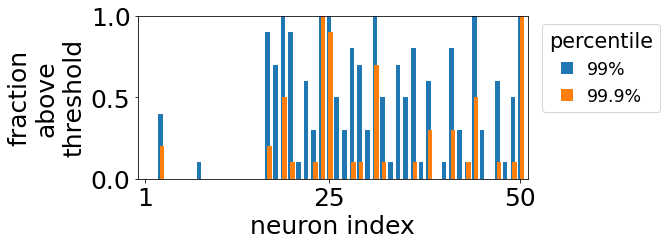

In [142]:
fig, ax = plt.subplots(figsize=(7, 3))

ax.bar(arange(50), counts['171017_154139A_1'], width=.6, align='center')
ax.bar(arange(50)+.2, counts['171017_154139A_.1'], width=.6, align='center')

leg = ax.legend(('99%', '99.9%'), loc=1,
             bbox_to_anchor=(1.36,1), fontsize='x-small', handlelength=.7)
leg.set_title('percentile', prop={'size':'small'})
ax.set(xlabel='neuron index',
       ylabel='fraction\nabove\nthreshold',
       xlim=(-1,50), ylim=(0,1),
       xticks=[0,24,49], xticklabels=[1,25,50])

fig.savefig(f'{imgdr}/piv_neuron_hist_154139.pdf', bbox_inches='tight')

# Couplings spectra fit (examples)

In [162]:
base_name = '171017_154139'

Plotting subset A corr pert.
Plotting subset A can pert.
Plotting subset B corr pert.
Plotting subset B can pert.
Plotting subset C corr pert.
Plotting subset C can pert.
Plotting subset D corr pert.
Plotting subset D can pert.
Plotting subset A corr pert.
Plotting subset A can pert.
Plotting subset B corr pert.
Plotting subset B can pert.
Plotting subset C corr pert.
Plotting subset C can pert.
Plotting subset D corr pert.
Plotting subset D can pert.


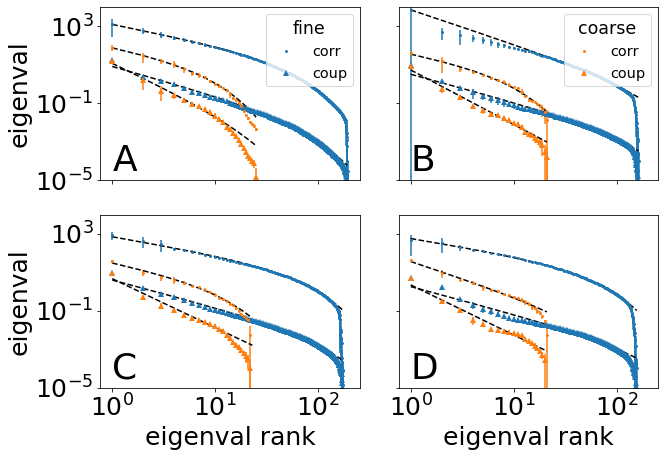

In [163]:
# comparing coupling-like perturbations
fig, ax = plt.subplots(figsize=(10,7), ncols=2, nrows=2,
                       sharey=True, sharex=True,
                       gridspec_kw={'wspace':.15, 'hspace':.2})
ax = ax.ravel()

h1 = pplt.grid4_J(ax, base_name, 1, mc='C0', show_fit=True, show_detail=False,
                  plot_kw={'ylim':(1e-5,1e4), 'xticks':(1,10,100)}, iprint=True)
h2 = pplt.grid4_J(ax, base_name, 2, mc='C1', show_fit=True, show_detail=False,
                  plot_kw={'ylim':(1e-5,1e4), 'xticks':(1,10,100)}, iprint=True)
    
leg = ax[0].legend((h1[-2], h1[-1]), ('corr', 'coup'),
                   fontsize='xx-small', loc=1)
leg.set_title('fine', prop={'size':'x-small'})
leg = ax[1].legend((h2[-2], h2[-1]), ('corr', 'coup'),
                   fontsize='xx-small', loc=1)
leg.set_title('coarse', prop={'size':'x-small'})

ax[0].text(1, 3e-5, 'A', fontsize='x-large')
ax[1].text(1, 3e-5, 'B', fontsize='x-large')
ax[2].text(1, 3e-5, 'C', fontsize='x-large')
ax[3].text(1, 3e-5, 'D', fontsize='x-large')

fig.savefig(f'{imgdr}/power_law_fit_{base_name}.pdf', bbox_inches='tight')

# Field/bias perturbations spectra

In [227]:
base_name = '171017_170419'

Text(1, 3e-05, 'D')

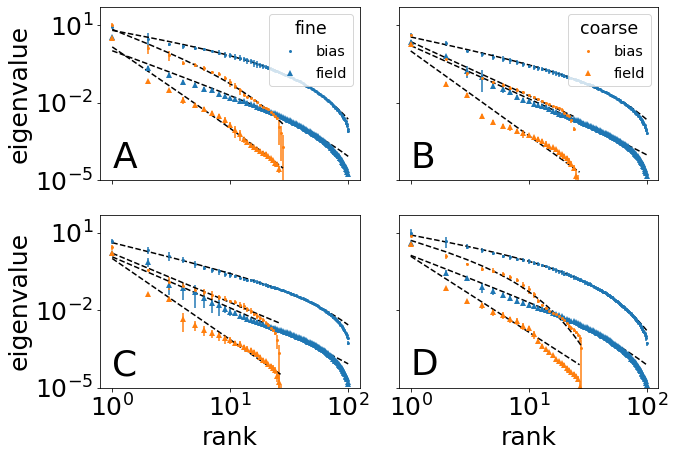

In [245]:
# comparing field-like perturbations
fig, ax = plt.subplots(figsize=(10,7), ncols=2, nrows=2,
                       sharey=True, sharex=True,
                       gridspec_kw={'wspace':.15, 'hspace':.2})
ax = ax.ravel()

h1 = pplt.grid4_h(ax, base_name, 1, mc='C0',
                  show_fit=True, iprint=False, show_detail=False,
                  plot_kw={'ylim':(1e-5,50), 'xticks':(1,10,100)})
h2 = pplt.grid4_h(ax, base_name, 2, mc='C1',
                  show_fit=True, iprint=False, show_detail=False,
                  plot_kw={'ylim':(1e-5,50), 'xticks':(1,10,100)})
    
leg = ax[0].legend((h1[-2], h1[-1]), ('bias', 'field'),
                   fontsize='xx-small', loc=1)
leg.set_title('fine', prop={'size':'x-small'})
leg = ax[1].legend((h2[-2], h2[-1]), ('bias', 'field'),
                   fontsize='xx-small', loc=1)
leg.set_title('coarse', prop={'size':'x-small'})

ax[0].text(1, 3e-5, 'A', fontsize='x-large')
ax[1].text(1, 3e-5, 'B', fontsize='x-large')
ax[2].text(1, 3e-5, 'C', fontsize='x-large')
ax[3].text(1, 3e-5, 'D', fontsize='x-large')

In [246]:
fig.savefig(f'{imgdr}/field_pert_spectra_{base_name}.pdf', bbox_inches='tight')

# MC sample size verification

In [258]:
small_soln = CoupSolution('171017_170419', 0, mc_ix='i')
large_soln = CoupSolution('171017_170419', 0, mc_ix='x')

Model file 171017_170419_modelA0ax.p not found.


In [259]:
sval, _, svec = small_soln.avg_eigvals(True)
lval, lvec = large_soln.eig()

[[], Text(0, 0.5, 'secondary')]

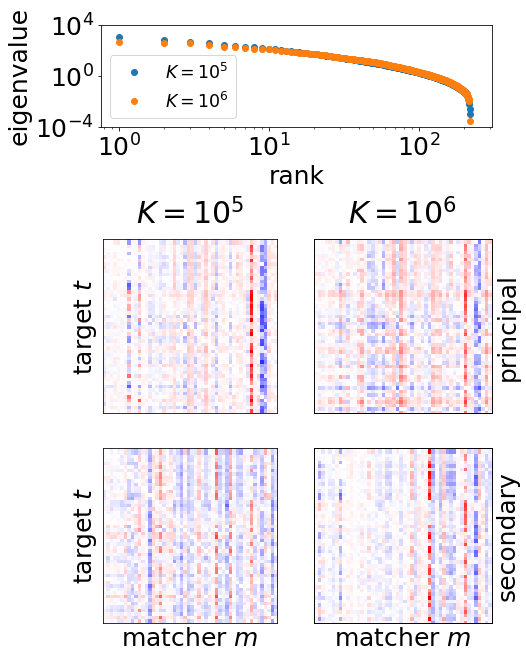

In [266]:
fig = plt.figure(figsize=(7,11))
gs = GridSpec(3, 2, fig,
              height_ratios=(1.5,2,2),
              hspace=.9)

ax = fig.add_subplot(gs[0,:])
ax.loglog(arange(1, 235), sval[:234], 'o')
ax.loglog(arange(1, 235), lval[:234], 'o')
ax.set(ylim=(1e-4, 1e4), xlabel='rank', ylabel='eigenvalue')
ax.set(yticks=(1e-4,1,1e4))
ax.legend((r'$K=10^5$', r'$K=10^6$'), fontsize='x-small')


ings = GridSpecFromSubplotSpec(2, 2, gs[1:,:])
inax = [fig.add_subplot(ings[0,0]),
        fig.add_subplot(ings[1,0]),
        fig.add_subplot(ings[0,1]),
        fig.add_subplot(ings[1,1])]

inax[0].matshow(vec2mat(svec[0][:,0]), cmap=plt.cm.seismic, vmin=-.25, vmax=.25)
inax[1].matshow(vec2mat(svec[0][:,1]*-1), cmap=plt.cm.seismic, vmin=-.25, vmax=.25)
inax[2].matshow(vec2mat(lvec[:,0]), cmap=plt.cm.seismic, vmin=-.25, vmax=.25)
inax[3].matshow(vec2mat(lvec[:,1]), cmap=plt.cm.seismic, vmin=-.25, vmax=.25)

for ax_ in inax:
    ax_.set(xticks=[], yticks=[])
inax[0].set(ylabel=r'target $t$', title=r'$K=10^5$')
inax[1].set(ylabel=r'target $t$')
inax[1].set(xlabel=r'matcher $m$')
inax[2].set(title=r'$K=10^6$')
inax[3].set(xlabel=r'matcher $m$')

axb = inax[2].twinx()
axb.set(ylabel='principal', yticks=[])
axb = inax[3].twinx()
axb.set(ylabel='secondary', yticks=[])

In [267]:
fig.savefig(f'{imgdr}/sample_size_comparison.pdf', bbox_inches='tight')

# Exponent fits

In [200]:
load_pickle('plotting/exponent_fits.p')

['alpha', 'zbar']

Text(2.8, 250.0, 'D')

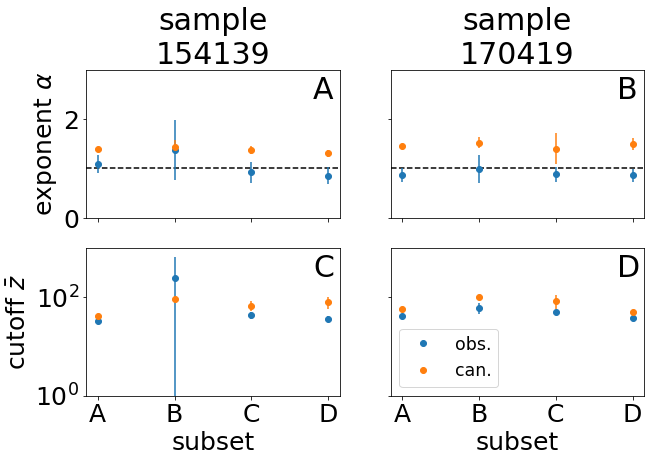

In [230]:
fig, ax = plt.subplots(figsize=(10,6), nrows=2, ncols=2,
                       sharex=True)

h = []
for i, (k, v) in enumerate(alpha[0].items()):
    if i<4:
    # plot every single fit exponent value in excruciating detail
#     ax[0].plot([i]*len(v), v, 'o', alpha=.2, c='C0', mew=0, zorder=1)
        h.append(ax[0,0].errorbar(i, mean(v), yerr=std(v, ddof=1),
                                  fmt='o', c='C0', zorder=2)[0])
    else:
        ax[0,1].errorbar(i-4, mean(v),
                         yerr=std(v, ddof=1), fmt='o', c='C0', zorder=2)
for i, (k, v) in enumerate(zbar[0].items()):
    if i<4:
        ax[1,0].errorbar(i, mean(v), yerr=std(v, ddof=1),
                         fmt='o', c='C0', zorder=2)
    else:
        ax[1,1].errorbar(i-4, mean(v), yerr=std(v, ddof=1), fmt='o', c='C0', zorder=2)
        
for i, (k, v) in enumerate(alpha[1].items()):
    # plot every single fit exponent value in excruciating detail
#     ax[0].plot([i]*len(v), v, 'o', alpha=.2, c='C0', mew=0, zorder=1)
    if i<4:
        h.append(ax[0,0].errorbar(i, mean(v), yerr=std(v, ddof=1),
                                  fmt='o', c='C1', zorder=2)[0])
    else:
        ax[0,1].errorbar(i-4, mean(v), yerr=std(v, ddof=1), fmt='o', c='C1', zorder=2)
for i, (k, v) in enumerate(zbar[1].items()):
    if i<4:
        ax[1,0].errorbar(i, mean(v), yerr=std(v, ddof=1), fmt='o', c='C1', zorder=2)
    else:
        ax[1,1].errorbar(i-4, mean(v), yerr=std(v, ddof=1), fmt='o', c='C1', zorder=2)

# plot formatting
ax[1,1].legend((h[0],h[4]), ('obs.','can.'), fontsize='x-small')

xlim = ax[0,0].get_xlim()
ax[0,0].hlines(1, *xlim, zorder=0, linestyles='--')
ax[0,1].hlines(1, *xlim, zorder=0, linestyles='--')
ax[0,0].set(ylim=(0,3), xlim=xlim, ylabel=r'exponent $\alpha$', title='sample\n154139')
ax[0,1].set(ylim=(0,3), xlim=xlim, title='sample\n170419', yticklabels=[])

ax[1,0].set(yscale='log')
ax[1,1].set(yscale='log')
ax[1,0].set(ylim=(1,1e3), ylabel=r'cutoff $\bar{z}$',
            xlabel='subset',
            xticks=range(4),
            xticklabels=['A','B','C','D']);
ax[1,1].set(ylim=(1,1e3),
            xlabel='subset',
            xticks=range(4),
            xticklabels=['A','B','C','D'],
            yticklabels=[]);
ax[0,0].text(2.8, 2.4, 'A', fontsize='large')
ax[0,1].text(2.8, 2.4, 'B', fontsize='large')
ax[1,0].text(2.8, 2.5e2, 'C', fontsize='large')
ax[1,1].text(2.8, 2.5e2, 'D', fontsize='large')

In [231]:
fig.savefig(f'{imgdr}/exponent_fits.pdf', bbox_inches='tight')

Text(2.8, 250.0, 'B')

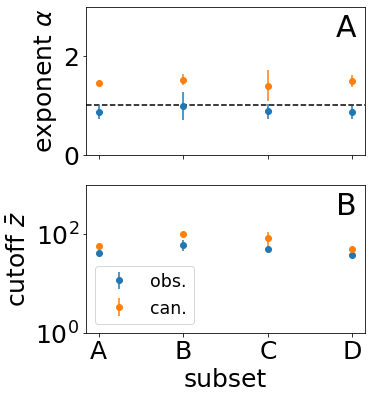

In [227]:
fig, ax = plt.subplots(figsize=(5,6), nrows=2,
                       sharex=True)
ax = ax.ravel()

h = []
for i, (k, v) in enumerate(alpha[0].items()):
    if i<4:
        pass
    else:
        h.append(ax[0].errorbar(i-4, mean(v),
                                yerr=std(v, ddof=1), fmt='o', c='C0', zorder=2))
for i, (k, v) in enumerate(zbar[0].items()):
    if i<4:
        pass
    else:
        ax[1].errorbar(i-4, mean(v), yerr=std(v, ddof=1), fmt='o', c='C0', zorder=2)
        
for i, (k, v) in enumerate(alpha[1].items()):
    # plot every single fit exponent value in excruciating detail
#     ax[0].plot([i]*len(v), v, 'o', alpha=.2, c='C0', mew=0, zorder=1)
    if i<4:
        pass
    else:
        h.append(ax[0].errorbar(i-4, mean(v), yerr=std(v, ddof=1), fmt='o', c='C1', zorder=2))
for i, (k, v) in enumerate(zbar[1].items()):
    if i<4:
        pass
    else:
        ax[1].errorbar(i-4, mean(v), yerr=std(v, ddof=1), fmt='o', c='C1', zorder=2)

# plot formatting
ax[1].legend((h[0],h[-1]), ('obs.','can.'), fontsize='x-small')

xlim = ax[0].get_xlim()
ax[0].hlines(1, *xlim, zorder=0, linestyles='--')
ax[0].set(ylim=(0,3), xlim=xlim, ylabel=r'exponent $\alpha$')
# ax[0].set(ylim=(0,3), xlim=xlim, ylabel=r'exponent $\alpha$', title='sample\n154139')

ax[1].set(yscale='log')
ax[1].set(ylim=(1,1e3),
          ylabel=r'cutoff $\bar{z}$',
            xlabel='subset',
            xticks=range(4),
            xticklabels=['A','B','C','D']);

ax[0].text(2.8, 2.4, 'A', fontsize='large')
ax[1].text(2.8, 2.5e2, 'B', fontsize='large')

In [228]:
fig.savefig(f'{imgdr}/exponent_fits_170419.pdf', bbox_inches='tight')

from "2020-09-24 FIM entry stats.ipynb"

In [120]:
load_pickle('plotting/uniformity_further_examples.p')

['cUniformity', 'rUniformity']

1090.8423964689184
1050.5890844896617
1114.3246373703223
1129.9552424465362
1121.3175509644718
1123.8844248747798


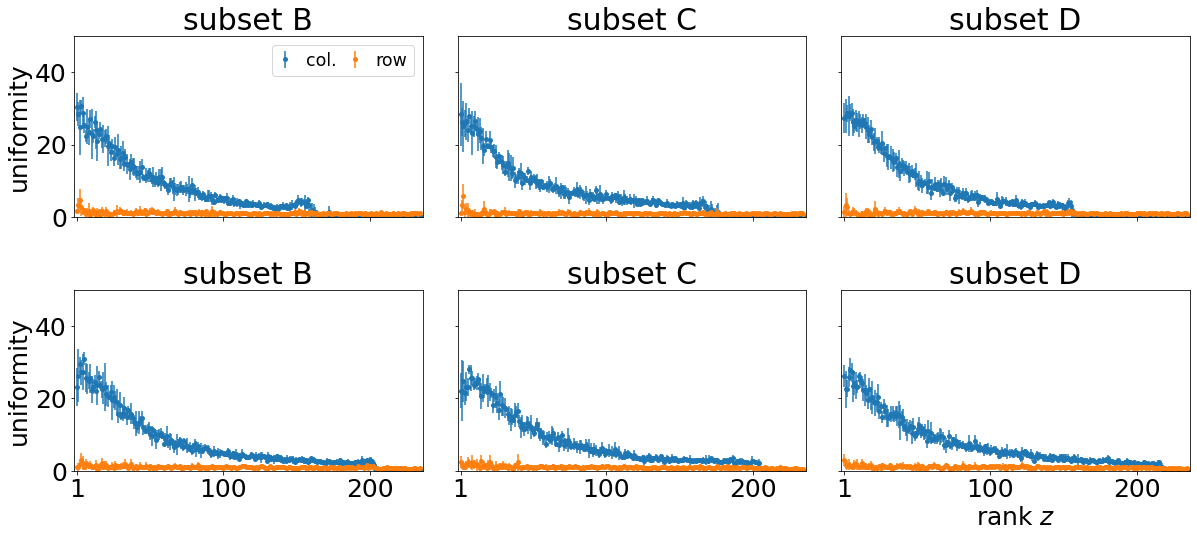

In [124]:
fig, ax = plt.subplots(figsize=(20,8), nrows=2, ncols=3,
                       gridspec_kw={'hspace':.4,'wspace':.1},
                       sharex=True, sharey=True)
ax = ax.ravel()

for i in range(6):
    h = []
    y1 = vstack(cUniformity[i])
    y2 = vstack(rUniformity[i])
    h.append(ax[i].errorbar(range(1,235), y1.mean(0), yerr=y1.std(0, ddof=1),
                        fmt='.', c='C0', zorder=2, mew=2))

    h.append(ax[i].errorbar(range(1,235), y2.mean(0), yerr=y2.std(0, ddof=1),
                            fmt='.', c='C1', zorder=2, mew=2))
    print(cumsum(y1.mean(0) - y2.mean(0)).mean())
    if i>4:
        ax[i].set(xlabel=r'rank $z$',
                  xlim=(-1, 236), xticks=(1,100,200),
                  ylim=(0,50))
    else:
        ax[i].set(xlim=(-1, 236), xticks=(1,100,200),
                  ylim=(0,50))
    ax[i].set_title('subset '+'BCD'[i%3])
    
    if i==0:
        ax[i].legend((h[0],h[1]), ('col.','row'),
                      loc='upper right',
                      fontsize='x-small',
                      handlelength=.75,
                      ncol=2,
                     columnspacing=.7)

    if i==0 or i==3:
        ax[i].set_ylabel('uniformity')
        
fig.savefig(f'{imgdr}/cfim_examples.pdf', bbox_inches='tight')

In [14]:
load_pickle('plotting/uniformity_indpt.p')

['cUniformity', 'rUniformity']

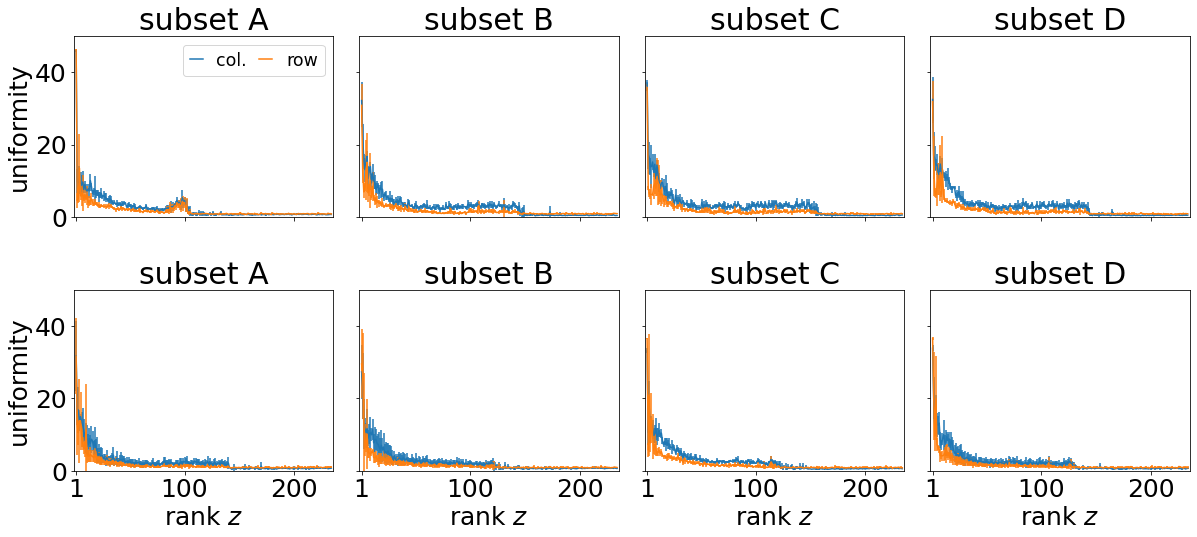

In [15]:
fig, ax = plt.subplots(figsize=(20,8), nrows=2, ncols=4,
                       gridspec_kw={'hspace':.4,'wspace':.1},
                       sharex=True, sharey=True)
ax = ax.ravel()

for i in range(8):
    h = []
    y1 = vstack(cUniformity[i])
    y2 = vstack(rUniformity[i])

    h.append(ax[i].errorbar(range(1,235), y1.mean(0), yerr=y1.std(0),
                            c='C0', zorder=2, mew=2)[0])
    h.append(ax[i].errorbar(range(1,235), y2.mean(0), yerr=y2.std(0),
                            c='C1', zorder=2, mew=2)[0])
    
    if i<4:
        ax[i].set(xlim=(-1, 236),
                  xticks=(1,100,200),
                  ylim=(0,50))
    else:
        ax[i].set(xlabel=r'rank $z$',
                  xlim=(-1, 236),
                  xticks=(1,100,200),
                  ylim=(0,50))
    ax[i].set_title('subset '+'ABCD'[i%4])
    
    if i==0:
        ax[i].legend((h[0],h[1]), ('col.','row'),
                      loc='upper right',
                      fontsize='x-small',
                      handlelength=.75,
                      ncol=2,
                     columnspacing=.7)

    if i==0 or i==4:
        ax[i].set_ylabel('uniformity')
        
fig.savefig(f'{imgdr}/cfim_indpt_examples.pdf', bbox_inches='tight')

In [12]:
load_pickle('plotting/uniformity_permute_examples.p')

['cUniformity', 'rUniformity']

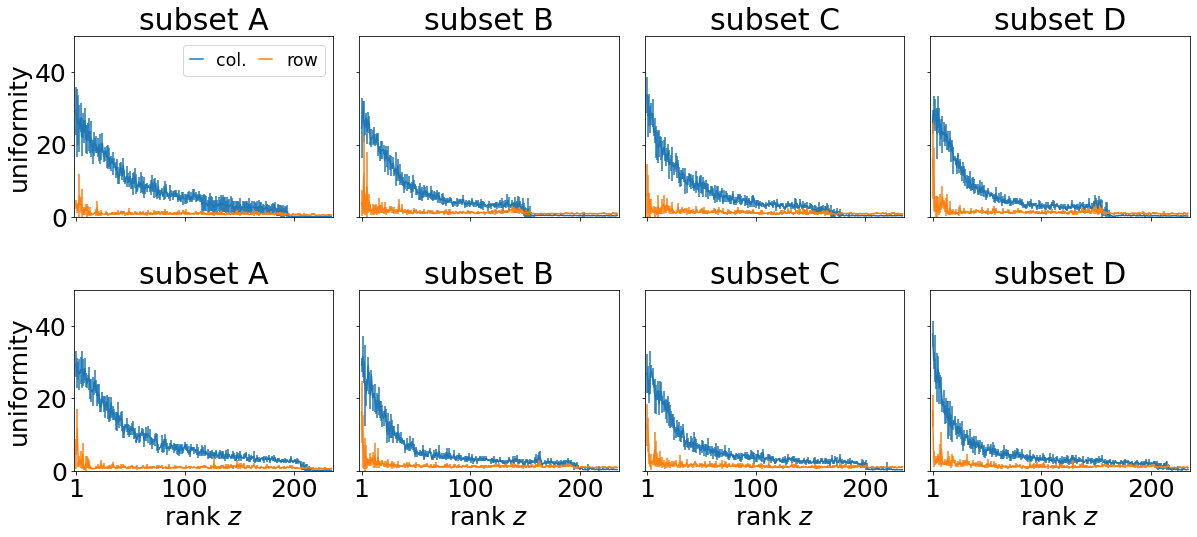

In [13]:
fig, ax = plt.subplots(figsize=(20,8), nrows=2, ncols=4,
                       gridspec_kw={'hspace':.4,'wspace':.1},
                       sharex=True, sharey=True)
ax = ax.ravel()

for i in range(8):
    h = []
    y1 = vstack(cUniformity[i])
    y2 = vstack(rUniformity[i])

    h.append(ax[i].errorbar(range(1,235), y1.mean(0), yerr=y1.std(0),
                            c='C0', zorder=2, mew=2)[0])
    h.append(ax[i].errorbar(range(1,235), y2.mean(0), yerr=y2.std(0),
                            c='C1', zorder=2, mew=2)[0])
    
    if i<4:
        ax[i].set(xlim=(-1, 236),
                  xticks=(1,100,200),
                  ylim=(0,50))
    else:
        ax[i].set(xlabel=r'rank $z$',
                  xlim=(-1, 236),
                  xticks=(1,100,200),
                  ylim=(0,50))
    ax[i].set_title('subset '+'ABCD'[i%4])
    
    if i==0:
        ax[i].legend((h[0],h[1]), ('col.','row'),
                      loc='upper right',
                      fontsize='x-small',
                      handlelength=.75,
                      ncol=2,
                     columnspacing=.7)

    if i==0 or i==4:
        ax[i].set_ylabel('uniformity')
        
fig.savefig(f'{imgdr}/cfim_permute_examples.pdf', bbox_inches='tight')

In [125]:
load_pickle('plotting/uniformity_mch.p')

['cUniformity', 'rUniformity']

1182.4773990203096
738.1882319438998
725.4439274104875
717.102617298386
1180.960910371055
951.6805125365627
922.0420954494734
913.581976126957


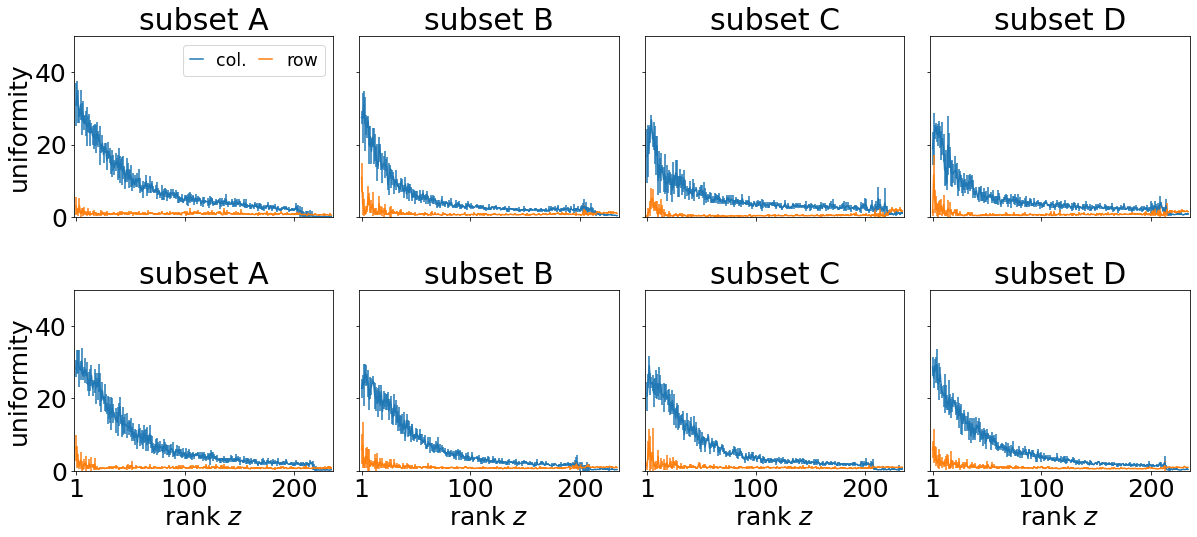

In [126]:
fig, ax = plt.subplots(figsize=(20,8), nrows=2, ncols=4,
                       gridspec_kw={'hspace':.4,'wspace':.1},
                       sharex=True, sharey=True)
ax = ax.ravel()

for i in range(8):
    h = []
    y1 = vstack(cUniformity[i])
    y2 = vstack(rUniformity[i])

    h.append(ax[i].errorbar(range(1,235), y1.mean(0), yerr=y1.std(0),
                            c='C0', zorder=2, mew=2)[0])
    h.append(ax[i].errorbar(range(1,235), y2.mean(0), yerr=y2.std(0),
                            c='C1', zorder=2, mew=2)[0])
    print(cumsum(y1.mean(0) - y2.mean(0)).mean())
    if i<4:
        ax[i].set(xlim=(-1, 236),
                  xticks=(1,100,200),
                  ylim=(0,50))
    else:
        ax[i].set(xlabel=r'rank $z$',
                  xlim=(-1, 236),
                  xticks=(1,100,200),
                  ylim=(0,50))
    ax[i].set_title('subset '+'ABCD'[i%4])
    
    if i==0:
        ax[i].legend((h[0],h[1]), ('col.','row'),
                      loc='upper right',
                      fontsize='x-small',
                      handlelength=.75,
                      ncol=2,
                     columnspacing=.7)

    if i==0 or i==4:
        ax[i].set_ylabel('uniformity')
        
fig.savefig(f'{imgdr}/cfim_mch.pdf', bbox_inches='tight')

# Panels of Figure 3

In [114]:
# files to load for analysis
soln = CoupSolution('171017_170419', 0, 'a', 'i')
fim = soln.fim()
model = soln.model()
eigval, eigvec = soln.eig()

eigix = 0
v = eigvec[:,eigix]
epsilon = 1e-4

dJ = model.dJ.T.dot(v)
dh = dJ[:150] * epsilon
dJ = dJ[150:] * epsilon

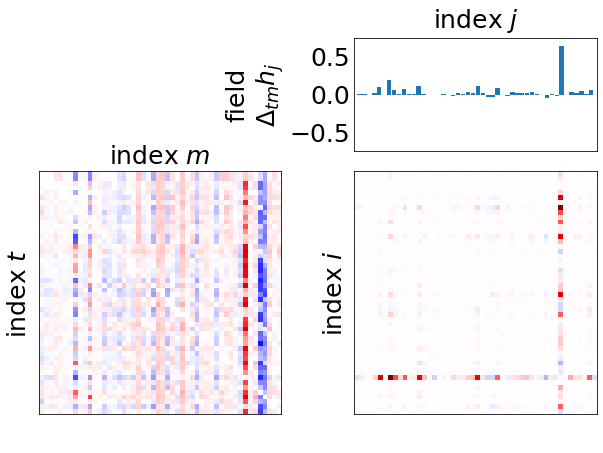

In [118]:
with_colorbar = False

fig = plt.figure(figsize=(10,7.5))
gs = GridSpec(1, 2,
              wspace=.3, hspace=.05)

subgs = GridSpecFromSubplotSpec(3, 1, gs[0,0],
                                height_ratios=(2.,5,.2),
                                hspace=.005)
gridax = fig.add_subplot(subgs[1])
cbarax = fig.add_subplot(subgs[2])
if not with_colorbar:
    cbarax.axis('off')

mx = .22
cax = gridax.matshow(vec2mat(v), vmin=-mx, vmax=mx, cmap=plt.cm.seismic)
gridax.set(xticklabels=[], yticklabels=[],
           xlabel=r'index $m$', ylabel=r'index $t$')
gridax.xaxis.set_label_position('top')
gridax.tick_params(length=0)
if with_colorbar:
    fig.colorbar(cax, cax=cbarax,
                 label=r'eigenvector $v_{tm}$',
                 orientation='horizontal')


subgs = GridSpecFromSubplotSpec(3, 1, gs[0,1],
                                height_ratios=(2.,5,.2),
                                hspace=.005)
topax = fig.add_subplot(subgs[0])
gridax = fig.add_subplot(subgs[1])
cbarax = fig.add_subplot(subgs[2])
if not with_colorbar:
    cbarax.axis('off')

# change in fields
mx = abs(dh).max()+.1
topax.bar(arange(50), dh[:50], zorder=1, width=.9)
# topax.bar(arange(50)+.5, dh[50:100], zorder=0, width=.3)
# topax.bar(arange(50)+.66, dh[100:150], zorder=-1, width=.3)
topax.set(ylim=(-mx,mx), xticklabels=[], xlim=(-.1,49.1),
          ylabel='field\n'+r'$\Delta_{tm} h_j$', xlabel=r'index $j$')
topax.xaxis.set_label_position('top')
topax.xaxis.labelpad = 10
topax.tick_params(length=0)

# change in couplings
dJmx = abs(dJ).max()
cax = gridax.matshow(squareform(dJ), vmin=-dJmx, vmax=dJmx, cmap=plt.cm.seismic)
gridax.xaxis.set_label_position('top')
gridax.set(xticklabels=[], yticklabels=[],
           ylabel=r'index $i$')
gridax.tick_params(length=0)
if with_colorbar:
    fig.colorbar(cax, cax=cbarax,
                 label=r'coupling $\Delta_{tm}\ J_{ij}$',
                 orientation='horizontal')

In [119]:
fig.savefig(f'{imgdr}/transform_ex1.pdf', bbox_inches='tight')

In [130]:
y = np.zeros(model.dJ.shape[1])
y[150] = dJmx  # set the first coupling to some nonzero value (arbitrarily set by cmap)
newvec, residuals, rank, s = linalg.lstsq(model.dJ.T, y)
newvec /= norm(newvec)

/home/eddie/anaconda3/envs/scotus4/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [131]:
def plot_perturbation(dh, dJ, newvec):
    fig = plt.figure(figsize=(10,5.5))
    gs = GridSpec(1, 2,
                  wspace=.3, hspace=.05)

    subgs = GridSpecFromSubplotSpec(2, 1, gs[0,0],
                                    height_ratios=(5,.2),
                                    hspace=.005)
    gridax = fig.add_subplot(subgs[0])
    cbarax = fig.add_subplot(subgs[1])

    mx = .22
    cax = gridax.matshow(vec2mat(newvec), vmin=-mx, vmax=mx, cmap=plt.cm.seismic)
    gridax.set(xticklabels=[], yticklabels=[],
               ylabel=r'index $t$')#, xlabel=r'index $m$')
    gridax.xaxis.set_label_position('top')
    gridax.tick_params(length=0)
    fig.colorbar(cax, cax=cbarax,
                 label=r'eigenvector $v_{tm}$',
                 orientation='horizontal')


    subgs = GridSpecFromSubplotSpec(2, 1, gs[0,1],
                                    height_ratios=(5,.2),
                                    hspace=.005)
    gridax = fig.add_subplot(subgs[0])
    cbarax = fig.add_subplot(subgs[1])

    cax = gridax.matshow(squareform(dJ), vmin=-dJmx, vmax=dJmx, cmap=plt.cm.seismic)
    gridax.xaxis.set_label_position('top')
    gridax.set(xticklabels=[], yticklabels=[],
               ylabel=r'index $i$')#, xlabel=r'index $j$')
    gridax.tick_params(length=0)
    
    fig.colorbar(cax, cax=cbarax,
                 label=r'coupling $\Delta_{tm}\ J_{ij}$',
                 orientation='horizontal')
    
    return fig

/home/eddie/anaconda3/envs/scotus4/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


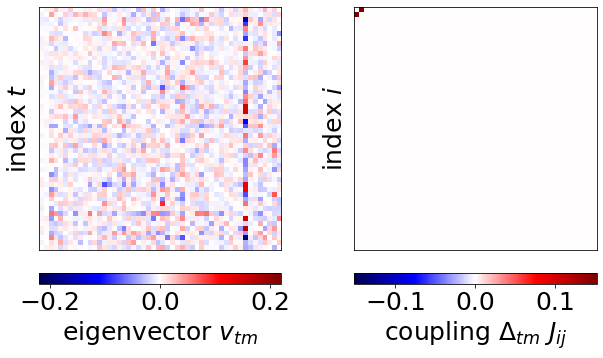

In [132]:
y = np.zeros(model.dJ.shape[1])
y[150] = dJmx  # set the first coupling to some nonzero value (arbitrarily set by cmap)
newvec, residuals, rank, s = linalg.lstsq(model.dJ.T, y)
newvec /= norm(newvec)

dh = np.zeros(150)
dJ = np.zeros(25*49)
dJ[150-150] = y[150]

fig = plot_perturbation(dh, dJ, newvec);

fig.savefig(f'{imgdr}/transform_ex2.pdf', bbox_inches='tight')

/home/eddie/anaconda3/envs/scotus4/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


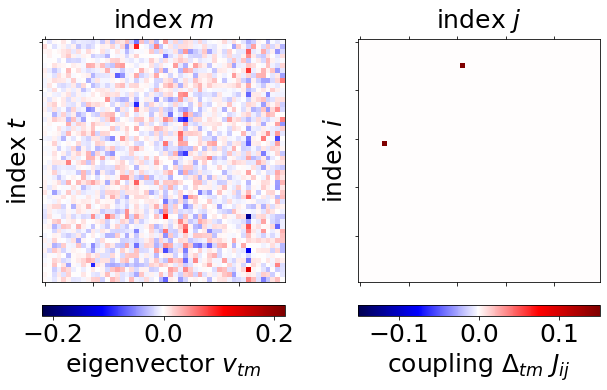

In [40]:
y = np.zeros(model.dJ.shape[1])
y[400] = dJmx  # set the first coupling to some nonzero value (arbitrarily set by cmap)
newvec, residuals, rank, s = linalg.lstsq(model.dJ.T, y)
newvec /= norm(newvec)

dh = np.zeros(150)
dJ = np.zeros(25*49)
dJ[400-150] = y[400]

plot_perturbation(dh, dJ, newvec);

fig.savefig(f'{imgdr}/transform_ex3.pdf', bbox_inches='tight')

# Model fit

In [234]:
def phi_fine_fit(base_name):
    soln = MESolution(f'171017_{base_name}',0,'a')

    n = soln.n
    X = soln.X()

    pairX = soln.model().allStates
    assert pairX.shape[0]==1e5

    indX = MESolution(f'171017_{base_name}_indpt',0,'a').model().allStates
    assert indX.shape[0]==1e5

    p, sync = cg.p_k(X)
    pair_p, pair_sync = cg.p_k(pairX)
    ind_p, ind_sync = cg.p_k(indX)

    # get subset of sync that are in both subsets
    sync_set = set([tuple(i) for i in sync]).intersection(set([tuple(i) for i in pair_sync]))
    sync_set = sync_set.intersection(set([tuple(i) for i in ind_sync]))

    # reorganize probabilities to same order
    sortix = []
    for s in sync_set:
        if (s==sync).all(1).any():
            sortix.append(np.where((s==sync).all(1))[0][0])
    p = p[sortix]
    sync = sync[sortix]

    sortix = []
    for s in sync_set:
        if (s==pair_sync).all(1).any():
            sortix.append(np.where((s==pair_sync).all(1))[0][0])
    pair_p = pair_p[sortix]
    pair_sync = pair_sync[sortix]

    sortix = []
    for s in sync_set:
        if (s==ind_sync).all(1).any():
            sortix.append(np.where((s==ind_sync).all(1))[0][0])
    ind_p = ind_p[sortix]
    ind_sync = ind_sync[sortix]

    return p, ind_p, pair_p

In [247]:
from misc.plot import seismic_cmap_kw

base_name = '170419'

soln = MESolution(f'171017_{base_name}',0,'a')

n = soln.n
X = soln.X()
sisjData = calc_observables(X).mean(0)
sisjModel = concatenate(soln.sisj())

shuff_soln = MESolution(f'171017_{base_name}_permute',0,'a','i')
model = shuff_soln.model()
shuff_sample = model.allStates

def plot_fit(n, sisjData, sisjModel, ax, c='C0',
             draw_legend=True):
    ax[0].plot(sisjData[:n], sisjModel[:n], '.', zorder=1)
    ax[0].plot(sisjData[n:n*2], sisjModel[n:n*2], 'x', zorder=1)
    ax[0].plot(sisjData[n*2:n*3], sisjModel[n*2:n*3], '^', zorder=1)
    ax[0].set(xlabel=r'data $p(s_{\rm i}=k)$',
              ylabel=r'model $p(s_{\rm i}=k)$',
              xlim=[-.02,1.02], ylim=[-.02,1.02], yticks=[0,.5,1.])
    draw_one_to_one(ax[0])
    if draw_legend:
        ax[0].legend((r'$p(s_i=\rm rise)$',r'$p(s_i=\rm fall)$'),
                     handletextpad=.05,
                     borderpad=.2,
                     fontsize=20)

    ax[1].plot(sisjData[n*3:], sisjModel[n*3:], '.', c=c, zorder=1)
    ax[1].set(xlabel=r'data $p(s_{\rm i}=s_{\rm j})$',
              ylabel=r'model $p(s_{\rm i}=s_{\rm j})$',
              xlim=[-.02,1.02], ylim=[-.02,1.02], yticks=[0,.5,1.])
    if draw_legend:
        ax[1].legend((r'$p(s_i=s_j)$',),
                     handletextpad=.05,
                     borderpad=.2,
                     fontsize=20)
    draw_one_to_one(ax[1])

Text(0.91, 0.44, 'D')

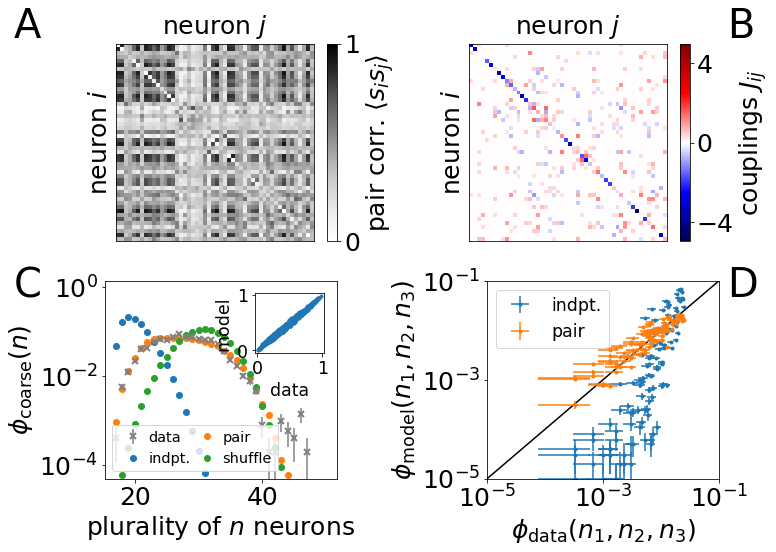

In [248]:
gs = GridSpec(2, 1)
gssub_top = GridSpecFromSubplotSpec(1, 2, gs[0], wspace=.35)
gssub_bot = GridSpecFromSubplotSpec(1, 2, gs[1], wspace=.65)

fig = plt.figure(figsize=(11,8))
ax = (fig.add_subplot(gssub_top[0]), fig.add_subplot(gssub_top[1]),
      fig.add_subplot(gssub_bot[0]), fig.add_subplot(gssub_bot[1]))

X = squareform(sisjData[150:])
X[diag_indices_from(X)] = sisjData[:50]
cax = ax[0].matshow(X, vmin=0, vmax=1, cmap=plt.cm.Greys)
ax[0].set(xticks=[], yticks=[], ylabel=r'neuron $i$')
ax[0].xaxis.set_label_position('top')
ax[0].set_xlabel(r'neuron $j$', labelpad=10)
fig.colorbar(cax, ax=ax[0], label=r'pair corr. $\langle s_is_j\rangle$', ticks=[0,1])

h, J = soln.parameters()
X = squareform(J)
X[diag_indices_from(X)] = h[:50]
cax = ax[1].matshow(X, **seismic_cmap_kw(X))
ax[1].set(xticks=[], yticks=[], ylabel=r'neuron $i$')
ax[1].xaxis.set_label_position('top')
ax[1].set_xlabel(r'neuron $j$', labelpad=10)
mx = concatenate((abs(h),abs(J))).max()
fig.colorbar(cax, ax=ax[1], label=r'couplings $J_{ij}$',
             ticks=[-int(mx),0,int(mx)])

# maxent fit ==============================================================
axinset = (inset_axes(ax[2], loc=1, width='30%', height='30%'),)

# # ax = fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])
axinset[0].plot(sisjData, sisjModel,'.')
axinset[0].set_xticklabels(['',0,1], fontsize='x-small')
axinset[0].set_yticklabels(['',0,1], fontsize='x-small')
axinset[0].set_xlabel('data', fontsize='x-small')
axinset[0].set_ylabel('model', fontsize='x-small')


# collective stats ==============================================================
X, pkdata, pkind, pkmaxent = collective_fit(soln.name)
pkshuff = extract_pk(shuff_sample)
h = []

# data
h.append( ax[2].errorbar(range(int(np.ceil(X.shape[1]/3)), X.shape[1]+1), pkdata,
                         yerr=np.sqrt(pkdata*(1-pkdata)/len(X)),
                         fmt='x', c='gray', mew=2) )

# indpt model
h.append( ax[2].plot(range(int(np.ceil(X.shape[1]/3)), X.shape[1]+1), pkind, 'o')[0] )

# maxent model
# assert len(model.p)==len(model.allStates)
h.append( ax[2].plot(range(int(np.ceil(X.shape[1]/3)), X.shape[1]+1), pkmaxent, 'o')[0] )

h.append( ax[2].plot(range(int(np.ceil(X.shape[1]/3)), X.shape[1]+1), pkshuff, 'o')[0] )

ax[2].set(yscale='log')
ax[2].set(yticks=[1e-4,1e-2,1])
ax[2].set(xlabel=r'plurality of $n$ neurons', ylabel=r'$\phi_{\rm coarse}(n)$',
          ylim=(1e-4/2,1.4))
ax[2].legend(h, ('data', 'indpt.', 'pair', 'shuffle'),
             fontsize='xx-small', handletextpad=.1, loc=3, ncol=2, columnspacing=.1)

p, ind_p, pair_p = phi_fine_fit('154139')

h = []
h.append(ax[3].errorbar(p, ind_p,
                        xerr=np.sqrt(p*(1-p)) / sqrt(X.shape[0]),
                        yerr=np.sqrt(ind_p*(1-ind_p)) / sqrt(1e5),
                        fmt='.',
                        zorder=1))
h.append(ax[3].errorbar(p, pair_p,
                        xerr=np.sqrt(p*(1-p)) / sqrt(X.shape[0]),
                        yerr=np.sqrt(pair_p*(1-pair_p)) / sqrt(1e5),
                        fmt='.',
                        zorder=1))
ax[3].loglog([1e-5, .1], [1e-5, .1], 'k-', zorder=0)

ax[3].set(xlabel=r'$\phi_{\rm data}(n_1,n_2,n_3)$', ylabel=r'$\phi_{\rm model}(n_1,n_2,n_3)$',
       xscale='log', yscale='log')
ax[3].set(xlim=(1e-5, .1), ylim=(1e-5, .1))
ax[3].legend(h, ('indpt.', 'pair'), fontsize='x-small')

fig.text(.01, .89, 'A', fontsize=40)
fig.text(.91, .89, 'B', fontsize=40)
fig.text(.01, .44, 'C', fontsize=40)
fig.text(.91, .44, 'D', fontsize=40)

In [249]:
fig.savefig(f'{imgdr}/{soln.name}_model_fit_overview.pdf',
            bbox_inches='tight')

## FIM overview
from "2020-06-26 scaling of sensitivity.ipynb"

In [189]:
def plot_scaling(ax, sample, max_val=None, x_offset=0, **plot_kw):
    y = np.zeros((len(sample), len(n_comp_range)))
    
    for j, s in enumerate(sample):
        for i, (ncomp, val) in enumerate(zip(n_comp_range, s)):
            y[j,i] = val.mean()
    # normalize to 1
    if max_val is None:
        y /= y[:,-1][:,None]
    else:
        if isinstance(max_val, ndarray) and max_val.ndim==1:
            y /= max_val[:,None]
        else:
            y /= max_val
    
    h = ax.errorbar(np.array(n_comp_range)+x_offset, y.mean(0), yerr=y.std(0), **plot_kw)
    return h

In [190]:
base_name = '171017_154139'

# calculate uniformity
u_row = np.zeros((4, 234))
u_col = np.zeros((4, 234))
for i, mc_ix in enumerate(['i','ii','iii','iv']):
    soln = CoupSolution(base_name, 0, 'a', mc_ix)
    val, vec = sorted_eigh(soln.fim())
    mats = []
    for j in range(234):
        mats.append( vec2mat(vec[:,j]) )
        
    u_row[i] = [(m.sum(1)**2).sum() for m in mats]
    u_col[i] =  [(m.sum(0)**2).sum() for m in mats]
    
avgval, vals = soln.avg_eigvals()
nonzeroix = avgval>1e-7
u_row[:,~nonzeroix[:234]] = 0
u_col[:,~nonzeroix[:234]] = 0

# load eigenvalue spectrum
eigvals = []
eigstd = []
nonzeroix = []

# maxent model
soln = CoupSolution(base_name, 0, 'a', 'i')
av, v = soln.avg_eigvals()
eigvals.append(av)
eigstd.append(v.std(0, ddof=1))
nonzeroix.append(av>1e-7)

# indpt
soln = CoupSolution(base_name+'_indpt', 0, 'a', 'i')
av, v = soln.avg_eigvals()
eigvals.append(av)
eigstd.append(v.std(0, ddof=1))
nonzeroix.append(av>1e-7)

# permutation
v = []
soln = CoupSolution(base_name+'_permute', 0, 'a', 'i')
av, v = soln.avg_eigvals()
eigvals.append(av)
eigstd.append(v.std(0, ddof=1))
nonzeroix.append(av>1e-7)

# canonical
soln = CanonicalCouplingSolution(base_name, 0, 'a', 'i')
av, v = soln.avg_eigvals()
eigvals.append(av)
eigstd.append(v.std(0, ddof=1))
nonzeroix.append(av>1e-7)


# set all values below threshold to 0
for i in range(len(eigvals)):
    eigvals[i][~nonzeroix[i]] = 0
    eigstd[i][~nonzeroix[i]] = 0

Model file 171017_154139_modelA0ai.p not found.


Text(0.13, 0.235, 'C')

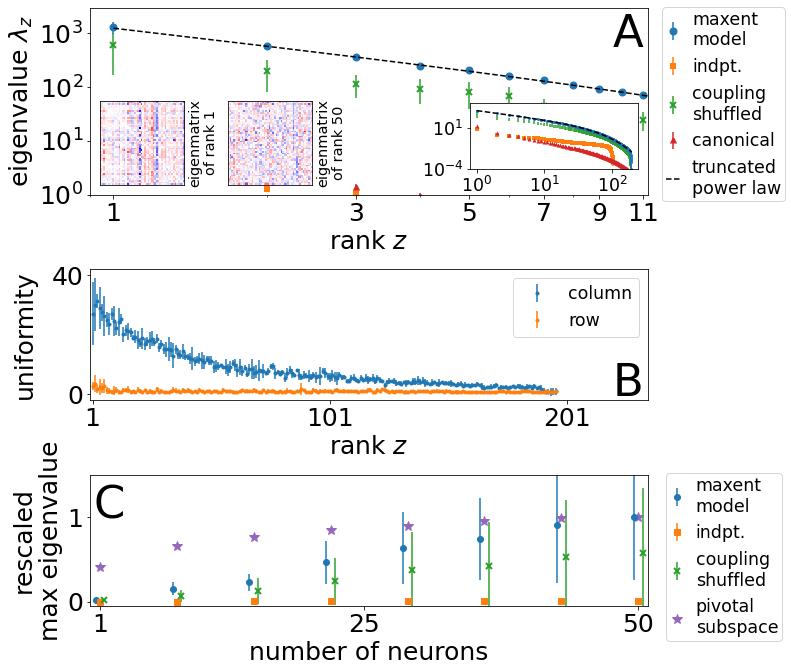

In [191]:
fig, ax = plt.subplots(3, 1, figsize=(10,11),
                       gridspec_kw={'hspace':.5, 'height_ratios':(1,.7,.7)})
ax = ax.ravel()
ax = ax[0], ax[2], ax[1]

# inset of spectrum ======================================================
h = []

axinset = inset_axes(ax[0], width="30%", height="35%",
                     borderpad=1.2, bbox_to_anchor=(.035,-.35,1,1),
                     bbox_transform=ax[0].transAxes)

axinset.errorbar(range(1, 2451), eigvals[0],
                 yerr=eigstd[0]/sqrt(10),
                 fmt='.',
                 mew=0)
# indpt neurons
h.append(axinset.errorbar(range(1, 2451), eigvals[1],
                          yerr=eigstd[1]/2,
                          fmt='s',
                          mew=0, ms=4, zorder=0)[0])
# permutation
h.append(axinset.errorbar(range(1, 2451), eigvals[2],
                          yerr=eigstd[2]/2,
                          fmt='x', mew=0, ms=4, zorder=0)[0])
# canonical
h.append(axinset.errorbar(range(1, 1226), eigvals[3],
                          yerr=eigstd[3]/2,
                          fmt='^', mew=0, ms=4, zorder=0)[0])

axinset.set(xscale='log', yscale='log', ylim=(1e-4,1e4))
axinset.set(xticks=(1,10,100), xlim=(.8,240))
[el.set_fontsize('x-small') for el in axinset.xaxis.get_ticklabels()]
[el.set_fontsize('x-small') for el in axinset.yaxis.get_ticklabels()]


# main eigenspectrum ================================================
h = []
x = arange(1, nonzeroix[0].sum()+1)
fitfun = fit_decay_power_law(eigvals[0][nonzeroix[0]], auto_upper_cutoff=-3)[0]
h.append(ax[0].errorbar(range(1, 2451), eigvals[0],
                        yerr=eigstd[0]/sqrt(10),
                        fmt='o', ms=7, zorder=1))
h.append(ax[0].loglog(x, fitfun(x), 'k--')[0])
axinset.loglog(x, fitfun(x), 'k--', zorder=3)
axinset.set(xticks=(1,10,100), xlim=(.8,240))

h.append(ax[0].errorbar(range(1, 2451), eigvals[1],
                        yerr=eigstd[1]/2,
                        fmt='s',
                        mew=2, ms=4, zorder=0))
h.append(ax[0].errorbar(range(1,2451), eigvals[2],
                        yerr=eigstd[2]/2,
                        fmt='x', mew=2, zorder=0))
h.append(ax[0].errorbar(range(1, 1226), eigvals[3],
                        yerr=eigstd[3]/2,
                        fmt='^', mew=2, ms=4, zorder=0))

ax[0].set(xlabel=r'rank $z$', ylabel=r'eigenvalue $\lambda_z$',
          xlim=(.9,10/.89), ylim=(1,3e3),
          yticks=(1,10,1e2,1e3),
          xticks=[1,3,5,7,9,11],
          xticklabels=[1,3,5,7,9,11])

ax[0].legend((h[0],h[2],h[3],h[-1],h[1]),
             ['maxent\nmodel',
              'indpt.',
              'coupling\nshuffled',
              'canonical',
              'truncated\npower law'],
             fontsize='x-small',
             ncol=1, loc=1,
             bbox_to_anchor=(1.26,1.05),
             handletextpad=.7, borderpad=.2,
             columnspacing=.2, handlelength=.8)


# inset of eigenmatrix ================================================
axinset = inset_axes(ax[0], width="45%", height="45%",
                     bbox_transform=ax[0].transAxes,
                     bbox_to_anchor=(-.66,-.43,1,1))

soln = CoupSolution(base_name, 0, 'a', 'i')
eigval, eigvec = soln.eig()

v = eigvec[:,0]
cax = axinset.matshow(vec2mat(v), cmap=plt.cm.seismic, vmin=-.2, vmax=.2)
axinset.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axinset.set_ylabel('eigenmatrix\nof rank 1', fontsize='xx-small')
axinset.yaxis.set_label_position('right')


axinset = inset_axes(ax[0], width="45%", height="45%",
                     bbox_transform=ax[0].transAxes,
                     bbox_to_anchor=(-.43,-.43,1,1))

v = eigvec[:,50]
cax = axinset.matshow(vec2mat(v), cmap=plt.cm.seismic, vmin=-.2, vmax=.2)
axinset.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axinset.set_ylabel('eigenmatrix\nof rank 50', fontsize='xx-small')
axinset.yaxis.set_label_position('right')


# pivotal neuron number scaling =================================
load_pickle(f'cache/eigenvalue_scaling_{base_name}.p')

mx = mean([i[-1] for i in piv_val])
h.append(plot_scaling(ax[1], sample_val[:10], mx, x_offset=-.4, fmt='o'))
h.append(plot_scaling(ax[1], sample_val[10:14], mx, fmt='s'))
h.append(plot_scaling(ax[1], sample_val[14:18], mx, x_offset=.4, fmt='x', mew=2))

y = vstack(piv_val)
y /= y[:,-1][:,None]
h.append(ax[1].plot(n_comp_range, y.mean(0), '*', c='C4', ms=10)[0])

ax[1].set_xlabel(r'number of neurons')
ax[1].set_ylabel('rescaled\nmax eigenvalue')
ax[1].set(xticks=[1,25,50], xlim=(.1, 50.9), ylim=(-.05,1.5))
ax[1].legend(h[-4:], ['maxent\nmodel',
                      'indpt.',
                      'coupling\nshuffled',
                      'pivotal\nsubspace'],
             fontsize='x-small',
             ncol=1, loc=1,
             bbox_to_anchor=(1.255,1.08),
             handletextpad=.7, borderpad=.2,
             columnspacing=.2, handlelength=.8)


# uniformity ==================================================
ix = u_col.mean(0)>0
ax[2].errorbar(range(1,ix.sum()+1), u_col.mean(0)[ix], u_col.std(0, ddof=1)[ix],
               fmt='.')
ax[2].errorbar(range(1,ix.sum()+1), u_row.mean(0)[ix], u_row.std(0, ddof=1)[ix],
               fmt='.')
ax[2].set(xticks=(1,101,201), xlim=(0, 235), ylim=(-2, 42), yticks=(0, 40))
ax[2].set_xlabel(r'rank $z$')
ax[2].set_ylabel(r"uniformity", labelpad=15)
ax[2].legend(('column','row'), fontsize='x-small')

fig.text(.85, .83, 'A', size=45)
fig.text(.85, .39, 'B', size=45)
fig.text(.13, .235, 'C', size=45)

In [155]:
fig.savefig(f"{imgdr}/fim_overview_{base_name.split('_')[1]}.pdf",
            bbox_inches='tight')

# FIM overview for coarse collective stat

In [232]:
base_name = '171017_170419'

# calculate uniformity
u_row = np.zeros((4, 234))
u_col = np.zeros((4, 234))
for i, mc_ix in enumerate(['i','ii','iii','iv']):
    soln = CoupSolution(base_name, 0, 'a', mc_ix, coarse_grain_type=2)
    val, vec = sorted_eigh(soln.fim())
    mats = []
    for j in range(234):
        mats.append( vec2mat(vec[:,j]) )
        
    u_row[i] = [(m.sum(1)**2).sum() for m in mats]
    u_col[i] =  [(m.sum(0)**2).sum() for m in mats]
    
avgval, vals = soln.avg_eigvals()
nonzeroix = avgval>1e-7
u_row[:,~nonzeroix[:234]] = 0
u_col[:,~nonzeroix[:234]] = 0

# load eigenvalue spectrum
eigvals = []
eigstd = []
nonzeroix = []

# maxent model
soln = CoupSolution(base_name, 0, 'a', 'i', coarse_grain_type=2)
av, v = soln.avg_eigvals()
eigvals.append(av)
eigstd.append(v.std(0, ddof=1))
nonzeroix.append(av>1e-7)

# indpt
soln = CoupSolution(base_name+'_indpt', 0, 'a', 'i', coarse_grain_type=2)
av, v = soln.avg_eigvals()
eigvals.append(av)
eigstd.append(v.std(0, ddof=1))
nonzeroix.append(av>1e-7)

# permutation
v = []
soln = CoupSolution(base_name+'_permute', 0, 'a', 'i', coarse_grain_type=2)
av, v = soln.avg_eigvals()
eigvals.append(av)
eigstd.append(v.std(0, ddof=1))
nonzeroix.append(av>1e-7)

# canonical
soln = CanonicalCouplingSolution(base_name, 0, 'a', 'i', coarse_grain_type=2)
av, v = soln.avg_eigvals()
eigvals.append(av)
eigstd.append(v.std(0, ddof=1))
nonzeroix.append(av>1e-7)


# set all values below threshold to 0
for i in range(len(eigvals)):
    eigvals[i][~nonzeroix[i]] = 0
    eigstd[i][~nonzeroix[i]] = 0

Model file 171017_170419_modelA0ai.p not found.
Model file 171017_170419_modelA0aii.p not found.
Model file 171017_170419_modelA0aiii.p not found.
Model file 171017_170419_modelA0aiv.p not found.
Model file 171017_170419_modelA0ai.p not found.
Model file 171017_170419_indpt_modelA0ai.p not found.
Model file 171017_170419_permute_modelA0ai.p not found.


FileNotFoundError: [Errno 2] No such file or directory: 'cache/eigenvalue_scaling_coarse_171017_170419.p'

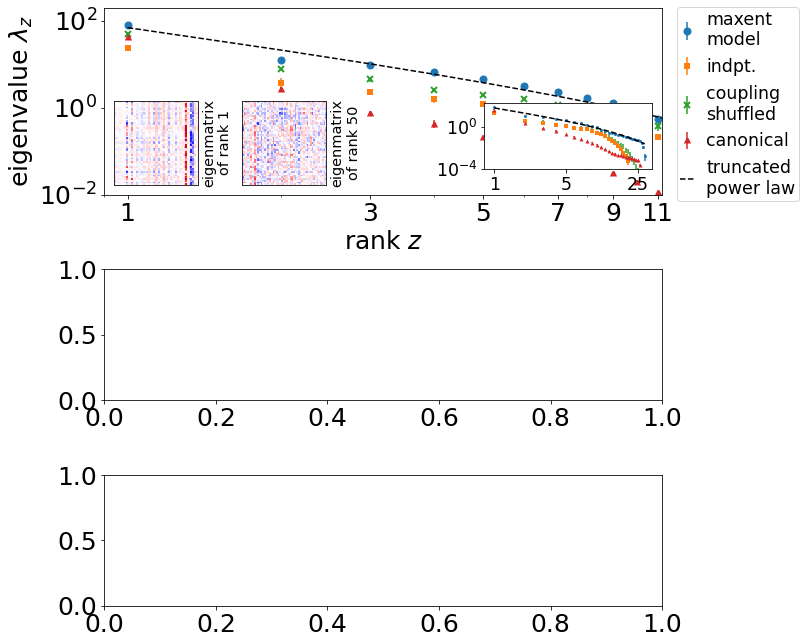

In [233]:
fig, ax = plt.subplots(3, 1, figsize=(10,11),
                       gridspec_kw={'hspace':.5, 'height_ratios':(1,.7,.7)})
ax = ax.ravel()
ax = ax[0], ax[2], ax[1]

# inset of spectrum ======================================================
h = []

axinset = inset_axes(ax[0], width="30%", height="35%",
                     borderpad=1.2, bbox_to_anchor=(.035,-.35,1,1),
                     bbox_transform=ax[0].transAxes)

axinset.errorbar(range(1, 2451), eigvals[0],
                 yerr=eigstd[0]/sqrt(10),
                 fmt='.',
                 mew=0)
# indpt neurons
h.append(axinset.errorbar(range(1, 2451), eigvals[1],
                          yerr=eigstd[1]/2,
                          fmt='s',
                          mew=0, ms=4, zorder=0)[0])
# permutation
h.append(axinset.errorbar(range(1, 2451), eigvals[2],
                          yerr=eigstd[2]/2,
                          fmt='x', mew=0, ms=4, zorder=0)[0])
# canonical
h.append(axinset.errorbar(range(1, 1226), eigvals[3],
                          yerr=eigstd[3]/2,
                          fmt='^', mew=0, ms=4, zorder=0)[0])

axinset.set(xscale='log', yscale='log', ylim=(1e-4,2e2))
axinset.set(xticks=(1,5,25), xlim=(.8,34))
[el.set_fontsize('x-small') for el in axinset.xaxis.get_ticklabels()]
[el.set_fontsize('x-small') for el in axinset.yaxis.get_ticklabels()]


# main eigenspectrum ================================================
h = []
x = arange(1, nonzeroix[0].sum()+1)
fitfun = fit_decay_power_law(eigvals[0][nonzeroix[0]], auto_upper_cutoff=-3)[0]
h.append(ax[0].errorbar(range(1, 2451), eigvals[0],
                        yerr=eigstd[0]/sqrt(10),
                        fmt='o', ms=7, zorder=1))
h.append(ax[0].loglog(x, fitfun(x), 'k--')[0])
axinset.loglog(x, fitfun(x), 'k--', zorder=3)
axinset.set(xticks=(1,5,25), xlim=(.8,34), xticklabels=(1,5,25))

h.append(ax[0].errorbar(range(1, 2451), eigvals[1],
                        yerr=eigstd[1]/2,
                        fmt='s',
                        mew=2, ms=4, zorder=0))
h.append(ax[0].errorbar(range(1,2451), eigvals[2],
                        yerr=eigstd[2]/2,
                        fmt='x', mew=2, zorder=0))
h.append(ax[0].errorbar(range(1, 1226), eigvals[3],
                        yerr=eigstd[3]/2,
                        fmt='^', mew=2, ms=4, zorder=0))

ax[0].set(xlabel=r'rank $z$', ylabel=r'eigenvalue $\lambda_z$',
          xlim=(.9,10/.89), ylim=(1e-2,2e2),
          yticks=(1e-2,1,1e2),
          xticks=[1,3,5,7,9,11],
          xticklabels=[1,3,5,7,9,11])

ax[0].legend((h[0],h[2],h[3],h[-1],h[1]),
             ['maxent\nmodel',
              'indpt.',
              'coupling\nshuffled',
              'canonical',
              'truncated\npower law'],
             fontsize='x-small',
             ncol=1, loc=1,
             bbox_to_anchor=(1.26,1.05),
             handletextpad=.7, borderpad=.2,
             columnspacing=.2, handlelength=.8)


# inset of eigenmatrix ================================================
axinset = inset_axes(ax[0], width="45%", height="45%",
                     bbox_transform=ax[0].transAxes,
                     bbox_to_anchor=(-.66,-.43,1,1))

soln = CoupSolution(base_name, 0, 'a', 'i')
eigval, eigvec = soln.eig()

v = eigvec[:,0]
cax = axinset.matshow(vec2mat(v), cmap=plt.cm.seismic, vmin=-.2, vmax=.2)
axinset.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axinset.set_ylabel('eigenmatrix\nof rank 1', fontsize='xx-small')
axinset.yaxis.set_label_position('right')


axinset = inset_axes(ax[0], width="45%", height="45%",
                     bbox_transform=ax[0].transAxes,
                     bbox_to_anchor=(-.43,-.43,1,1))

v = eigvec[:,50]
cax = axinset.matshow(vec2mat(v), cmap=plt.cm.seismic, vmin=-.2, vmax=.2)
axinset.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axinset.set_ylabel('eigenmatrix\nof rank 50', fontsize='xx-small')
axinset.yaxis.set_label_position('right')


# pivotal neuron number scaling =================================
load_pickle(f'cache/eigenvalue_scaling_coarse_{base_name}.p')

mx = mean([i[-1] for i in piv_val])
h.append(plot_scaling(ax[1], sample_val[:4], mx, fmt='o'))
h.append(plot_scaling(ax[1], sample_val[4:8], mx, fmt='s'))
h.append(plot_scaling(ax[1], sample_val[8:12], mx, fmt='x', mew=2))

y = vstack(piv_val)
y /= y[:,-1][:,None]
h.append(ax[1].plot(n_comp_range, y.mean(0), '*', c='C4', ms=10)[0])

ax[1].set_xlabel(r'number of neurons')
ax[1].set_ylabel('max eigenvalue\ncaptured')
ax[1].set(xticks=[1,25,50], xlim=(.1, 50.9), ylim=(-.05,1.05))
ax[1].legend(h[-4:], ['maxent\nmodel',
                      'indpt.',
                      'coupling\nshuffled',
                      'pivotal\nsubspace'],
             fontsize='x-small',
             ncol=1, loc=1,
             bbox_to_anchor=(1.255,1.08),
             handletextpad=.7, borderpad=.2,
             columnspacing=.2, handlelength=.8)


# uniformity ==================================================
ix = u_col.mean(0)>0
ax[2].errorbar(range(1,ix.sum()+1), u_col.mean(0)[ix], u_col.std(0, ddof=1)[ix],
               fmt='.')
ax[2].errorbar(range(1,ix.sum()+1), u_row.mean(0)[ix], u_row.std(0, ddof=1)[ix],
               fmt='.')
ax[2].set(xticks=(1,15,30), xlim=(0, 34), ylim=(-2,42), yticks=(0, 40))
ax[2].set_xlabel(r'rank $z$')
ax[2].set_ylabel(r"uniformity", labelpad=15)
ax[2].legend(('column','row'), fontsize='x-small')

fig.text(.85, .83, 'A', size=45)
fig.text(.85, .39, 'B', size=45)
fig.text(.13, .235, 'C', size=45)

In [157]:
fig.savefig(f"{imgdr}/fim_overview_coarse_{base_name.split('_')[1]}.pdf",
            bbox_inches='tight')